<a href="https://colab.research.google.com/github/Firojpaudel/Machine-Learning-Notes/blob/main/Practical%20Deep%20Learning%20For%20Coders/Chapter_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Modeling Deep Dive

In [5]:
#@ First Setting up the notebook:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
#@ Also installing the dependencies and necessary fastai's libraries
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.callback.fp16 import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


**Objective:**

To predict the value in one column based on the values in other columns.

---

### **1. Categorical Embeddings**

#### A. Introduction



In tabular data, some columns may contain numerical data, like `age`, while others contain string values, like `sex`. The numerical data can be directly fed to the model (with some optional preprocessing), but the other columns need to be converted to numbers. Since the values in those correspond to different categories, we often call this type of variables **categorical variables**. The first type are called **continuous variables**.

<details>
<summary>
<b>Jargon: Continuous and Categorical Variables</b>
</summary>
<ul>
<li><b>Continuous variables</b> are numerical data, such as <code>age</code>, that can be directly fed to the model, since you can add and multiply them directly.</li>
<li><b>Categorical variables</b> contain a number of discrete levels, such as <code>movie ID</code>, for which addition and multiplication don’t have meaning (even if they’re stored as numbers).</li>
</ul>
</details>

##### **Example:** *Rossmann Sales Competition*
At the end of 2015, the Rossmann sales competition ran on Kaggle. Competitors were given a wide range of information about various stores in Germany and were tasked with trying to predict sales on a number of days. The goal was to help the company manage stock properly and satisfy demand without holding unnecessary inventory.

One of the gold medalists used **deep learning**, in one of the earliest examples of a state-of-the-art deep learning tabular model. Their method involved far less feature engineering based on domain knowledge than those of the other gold medalists.

The paper ["Entity Embeddings of Categorical Variables"](https://arxiv.org/abs/1604.06737) by Cheng Guo and Felix Bekhahn describes their approach:
- **Advantages of Entity Embeddings**:
  - Reduces memory usage and speeds up neural networks compared with one-hot encoding.
  - Maps similar values close to each other in the embedding space, revealing intrinsic properties of categorical variables.
  - Useful for datasets with high cardinality features where other methods tend to overfit.
  - Defines a distance measure for categorical variables, enabling visualization and clustering.

  ***

##### ***Key Insights from the Paper:***
1. **Equivalence of Embedding Layers and Linear Layers**: An embedding layer is equivalent to placing an ordinary linear layer after every one-hot encoded input layer.
2. **Embedding Weights Analysis**:
   - Transforms categorical variables into inputs that are both continuous and meaningful.
   - Embedding distances often align with intuitive or real-world distances (e.g., geographic distance for states).

---

#### B. Visualizing Embeddings

The embeddings learned can reveal patterns in categorical data:
1. **State Embeddings**: Embeddings for German states learned their relative positions based solely on sales data.
2. **Date Embeddings**: Days of the week or months close in time are also close in the embedding space.

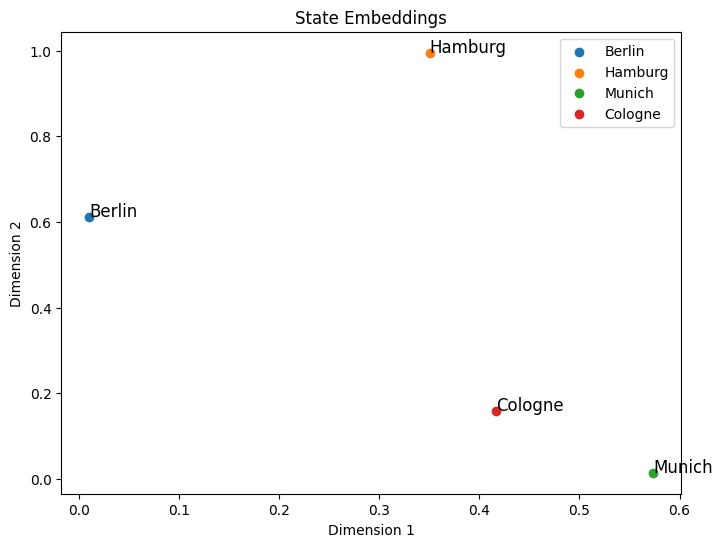

In [6]:
"Example code 1:"
import matplotlib.pyplot as plt
import numpy as np

# Simulated embedding data for states
states = ['Berlin', 'Hamburg', 'Munich', 'Cologne']
embeddings = np.random.rand(len(states), 2)

plt.figure(figsize=(8, 6))
for i, state in enumerate(states):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], label=state)
    plt.text(embeddings[i, 0], embeddings[i, 1], state, fontsize=12)

plt.title('State Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

The above code simulates and visualizes embeddings for states. The scatter plot shows embeddings projected into two dimensions, and annotations indicate which state each point corresponds to. This visualization can help identify patterns, such as how similar states cluster together in the embedding space.

The next code snippet simulates embeddings for days of the week. Each point in the scatter plot represents a day, with proximity in the plot reflecting similarity in the learned embedding space. For instance, weekdays may group together, while weekends might form their own cluster.

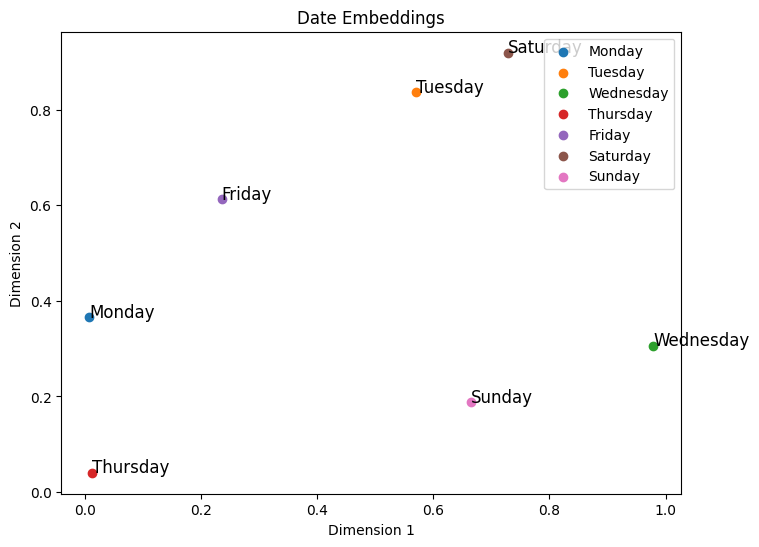

In [7]:
"Example Code 2:"
# Simulated embedding data for days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
embeddings = np.random.rand(len(days), 2)

plt.figure(figsize=(8, 6))
for i, day in enumerate(days):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], label=day)
    plt.text(embeddings[i, 0], embeddings[i, 1], day, fontsize=12)

plt.title('Date Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

---
#### C. Benefits of Embeddings


1. **Continuous Representation**: Models are better at understanding continuous variables.
2. **Efficient Integration**: Continuous embeddings can be concatenated with other continuous input data before being fed into a dense layer.

---

#### D. Real-World Application: *Google Play Recommendations*


Google’s recommendation system, as explained in the paper ["Wide & Deep Learning for Recommender Systems"](https://arxiv.org/abs/1606.07792), combines embeddings with both cross-product and neural network approaches. This hybrid system achieves state-of-the-art performance.

> Deep learning also works very well for collaborative filtering. But it is not
 always the best starting point for analyzing tabular data.

### **2. Beyond Deep Learning**

Modern machine learning can largely be summarized into two highly effective approaches:

1. **Ensembles of Decision Trees**
   - Examples: Random forests, Gradient Boosting Machines (e.g., XGBoost, LightGBM, CatBoost).
   - Best suited for structured/tabular data (e.g., datasets from database tables).
   - Advantages:
     - Faster training.
     - Easier to interpret.
     - No need for specialized GPU hardware.
     - Mature ecosystem and tooling.
     - Requires less hyperparameter tuning.
   - Tools for interpretability:
     - Identifying important features.
     - Understanding feature relationships with the target variable.
     - Explaining predictions for specific observations.

2. **Multilayered Neural Networks (Deep Learning)**
   - Examples: CNNs, RNNs, Transformers.
   - Best suited for unstructured data (e.g., images, audio, text).
   - Nearly always superior for unstructured data but may overlap with tree-based models for structured data.

> **Guideline:** Start with decision tree ensembles for structured data unless high-cardinality categorical variables or unstructured data are present.

---

#### A. Dataset for Demonstration: *Blue Book for Bulldozers*

**Problem:** Predict the auction sale price of heavy equipment based on features like usage, equipment type, and configuration.

**Source:** Kaggle competition (requires registration and Kaggle API for downloading data).

In [ ]:
##@ Installing the Kaggle API:
!pip install kaggle